Today, we will try to recognise digits in image using neural networks

In [21]:
import torch
import torchvision
import numpy as np
import random as rd

In [22]:
#update hyperparameters for dataset
# hyperpara are values used to adjust model parameters
#no of epoch is no of times you go over training data
numEpochs = 3
#batch size is size of data chunk used each time for training or testing
#optimizer is teaching the model and monitoring the momentum
batch_size_train = 64
batch_size_test = 64
# rate at which neural network learns
learning_rate = 0.01
#momentum is speedup in learning rate expanding on current learning velocity
momentum = 8.5

log_intervals = 10

In [23]:
random_seed = 1996
torch.manual_seed(random_seed)
np.random.seed(random_seed)
rd.seed(random_seed)

In [24]:
#load the datasets
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))


test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))


In [25]:
#load dataset in a format that pytorch can use
from torch.utils.data import DataLoader
train_dataloader1 = DataLoader(train_dataset,shuffle = True,batch_size = batch_size_train)
test_dataloader1 = DataLoader(test_dataset,shuffle = True,batch_size = batch_size_test)


In [26]:
#dealing with many mini datapoints/rows in a dataset and gives it one a t a time
examplesEnumerator = enumerate(test_dataloader1)

In [27]:
batch_id_for_example, (exampleDate, exampleLable) = next(examplesEnumerator)
print("batch_id_for_example =" ,batch_id_for_example)
print("exampleDate =" ,exampleDate.shape)
print("exampleLable =" ,exampleLable)

batch_id_for_example = 0
exampleDate = torch.Size([64, 1, 28, 28])
exampleLable = tensor([8, 5, 7, 5, 2, 7, 7, 9, 9, 2, 0, 1, 6, 0, 9, 7, 2, 6, 0, 3, 4, 8, 0, 6,
        9, 7, 2, 5, 8, 6, 5, 3, 6, 4, 6, 9, 5, 3, 6, 7, 0, 2, 9, 9, 8, 2, 8, 0,
        4, 6, 7, 7, 7, 6, 9, 8, 4, 2, 4, 3, 9, 1, 6, 2])


C:\Users\tusht\AppData\Local\Temp\ipykernel_17996\3295320960.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


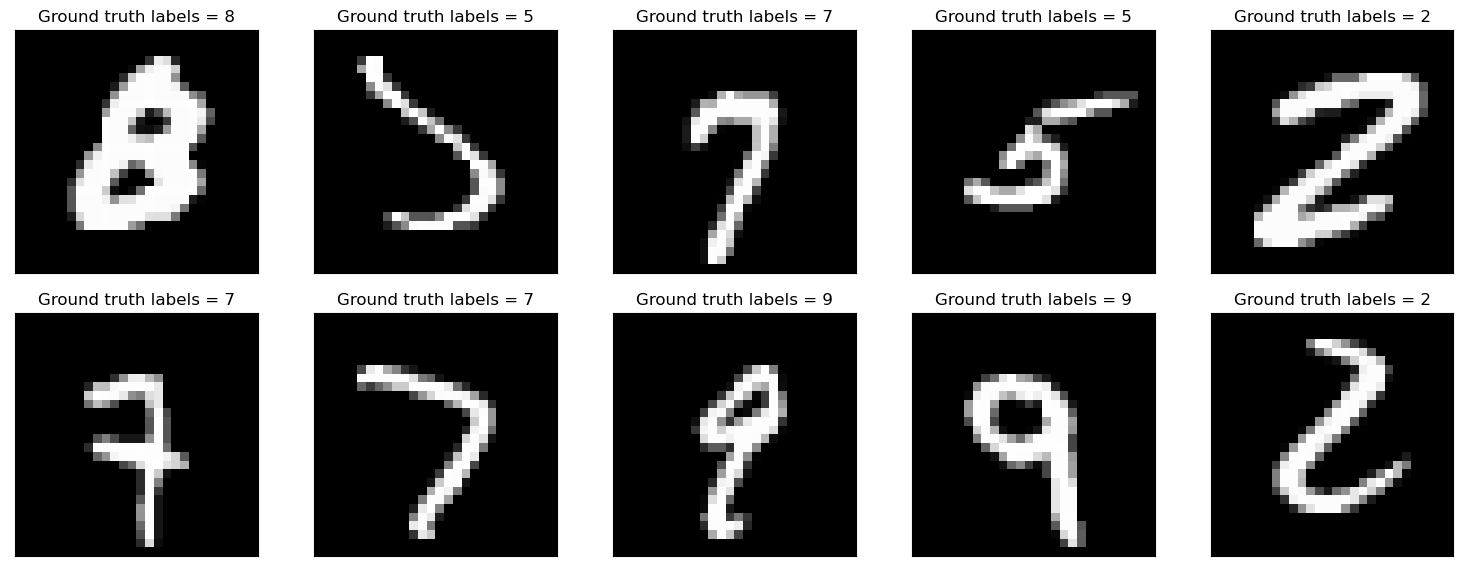

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))
for figureNumber in range(10):
    plt.subplot(2,5,figureNumber+1)
    plt.tight_layout()
    plt.imshow(exampleDate[figureNumber][0],cmap = 'gray',interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.title("Ground truth labels = %d"%exampleLable[figureNumber])

fig.show()


In [29]:
#load libraries for building tbe network
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [30]:
#Creating CNN - Convulution neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()#super->should initialize itself
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()#dropping the redundant info
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): #input some data x havinng 28*28
        x = F.relu(F.max_pool2d(self.conv1(x), 2))#relu -> rectified linear unit - if -ve then 0, otherwise keeping it as it is, max_pool -> output the largest no in the data, depending on its location,[pools the info and gives the max
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #softmax simply output max value, but does it within threshholds based on probability.
        return F.log_softmax(x)



In [31]:
#student = model
network = Net()
#teacher = optimizer
#SGD = stochastic gradient descent
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum)

In [32]:
#store the training value and arrays
train_losses = []
train_counter = []
test_losses = []
test_counter = []
print("len(train_dataloader.dataset)=",len(train_dataloader1.dataset))
test_counter = [i*len(train_dataloader1.dataset) for i in range(numEpochs+1)]
print("test_counter",test_counter)

len(train_dataloader.dataset)= 60000
test_counter [0, 60000, 120000, 180000]


In [33]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [34]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader1):
        optimizer.zero_grad()#not learning anything as of now
        output = network(data)
        loss = F.nll_loss(output, target)#student commit mistakes
        loss.backward()#student goes back to review
        optimizer.step()#determing the learning speed
        if batch_idx % log_intervals == 0:#printing the values
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader1.dataset),
                       100. * batch_idx / len(train_dataloader1), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_dataloader1.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader1:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader1.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader1.dataset),
        100. * correct / len(test_dataloader1.dataset)))

In [ ]:
test()
for epoch in range(1, numEpochs + 1):
    train(epoch)
    test()

C:\Users\tusht\AppData\Local\Temp\ipykernel_17996\4112713736.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3081, Accuracy: 950/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309765
Train Epoch: 1 [640/60000 (1%)]	Loss: 75760397012959232.000000
Train Epoch: 1 [1280/60000 (2%)]	Loss: nan
Train Epoch: 1 [1920/60000 (3%)]	Loss: nan
Train Epoch: 1 [2560/60000 (4%)]	Loss: nan
Train Epoch: 1 [3200/60000 (5%)]	Loss: nan
Train Epoch: 1 [3840/60000 (6%)]	Loss: nan
Train Epoch: 1 [4480/60000 (7%)]	Loss: nan
Train Epoch: 1 [5120/60000 (9%)]	Loss: nan
Train Epoch: 1 [5760/60000 (10%)]	Loss: nan
Train Epoch: 1 [6400/60000 (11%)]	Loss: nan
Train Epoch: 1 [7040/60000 (12%)]	Loss: nan
Train Epoch: 1 [7680/60000 (13%)]	Loss: nan
Train Epoch: 1 [8320/60000 (14%)]	Loss: nan
Train Epoch: 1 [8960/60000 (15%)]	Loss: nan
Train Epoch: 1 [9600/60000 (16%)]	Loss: nan
Train Epoch: 1 [10240/60000 (17%)]	Loss: nan
Train Epoch: 1 [10880/60000 (18%)]	Loss: nan
Train Epoch: 1 [11520/60000 (19%)]	Loss: nan
Train Epoch: 1 [12160/60000 (20%)]	Loss: nan
Train Epoch: 1 [12800/60000 (21%)]	Loss: nan
T